<img src ="Images/GatorGlaciologyLogo-01.jpg" width="100" align = "right">

# Interpolation with anisotropy
#### Gator Glaciology Lab, University of Florida

Geologic phenomena often have a directional component. Here, we demonstrate how to implement kriging and SGS with anisotropy.

In [1]:
# load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import geostatspy.geostats as geostats 
import skgstat as skg
from skgstat import models
import GStatSim as gs
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

## Load and plot data

<function matplotlib.pyplot.show(close=None, block=None)>

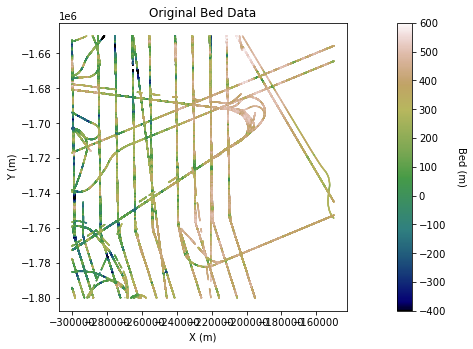

In [2]:
df_bed = pd.read_csv('Data/greenland_test_data.csv') # download data
df_bed = df_bed[df_bed["Bed"] <= 700]  # remove erroneously high values, presumably due to bad bed picks

# plot original data
im = plt.scatter(df_bed['X'],df_bed['Y'], c = df_bed['Bed'], vmin = -400, vmax = 600, marker=".", s = 0.5, 
                 cmap = 'gist_earth')       # scatter plot for location map
plt.title('Original Bed Data')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-400, 600, 11)) # add vertical color bar
cbar.set_label("Bed (m)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show

## Grid and transform data. Get variogram parameters

See variogram tutorials for details

In [3]:
# Grid data
res = 1000  # resolution
df_grid, grid_matrix, rows, cols = gs.grid_data(df_bed, 'X', 'Y', 'Bed', res) # grid data
df_grid = df_grid[df_grid["Z"].isnull() == False]  # remove coordinates with NaNs
df_grid = df_grid.rename(columns = {"Z": "Bed"}) # rename column for consistency

df_grid['Nbed'], tvbed, tnsbed = geostats.nscore(df_grid,'Bed')  # normal score transformation

# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 50000 # maximum range distance
n_lags = 70 #num of bins

V1 = skg.Variogram(coords, values, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)

V1.model = 'exponential' # use exponential variogram model
print(V1.parameters)

# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.pred_grid(xmin, xmax, ymin, ymax, res)

[31908.813487537744, 0.6983513514721337, 0]


## Simple kriging with anisotropy

Here we will implement simple kriging with anisotropy by adding 15 km to the the major range (a_maj). We chose an exaggerated range anisotropy for visualization purposes. However, the major and minor ranges would normally be determined by examining the variogram at different orientations.

In [4]:
# set variogram parameters
Azimuth = 0
nug = V1.parameters[2]
# the major and minor ranges are the same in this example because it is isotropic
a_maj = V1.parameters[0] + 15000
a_min = V1.parameters[0]
sill = 1 
vario = [Azimuth, nug, a_maj, a_min, sill] # save variogram parameters as a list

k = 100 # number of neighboring data points used to estimate a given point 
rad = 50000 # 50 km search radius

est_SK, var_SK = gs.skrige(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad) 
# est_SK is the estimate and var_SK is the variance

100%|████████████████████████████████████| 22500/22500 [02:23<00:00, 156.95it/s]


In [5]:
# reverse normal score transformation
df_skrige = pd.DataFrame(est_SK, columns = ['pred'])

# transformation parameters
vr = tvbed; vrg = tnsbed; ltail = 1; utail = 1; zmin = -4; zmax = 4; ltpar = -1500; utpar = 1500

# transformation
spred_trans = geostats.backtr(df_skrige,'pred',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)

<Figure size 432x288 with 0 Axes>

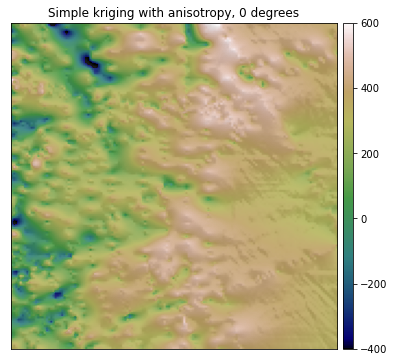

In [6]:
# make hillshade plot for visualizing

# reshape grid

ylen = (ymax + res - ymin)/res
xlen = (xmax + res - xmin)/res
elevation =  np.reshape(spred_trans, (int(ylen), int(xlen)))
elevation = elevation 

hillshade = es.hillshade(elevation, azimuth = 210, altitude = 10) # hillshade

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    elevation,
    ax=ax,
    cmap="gist_earth",
    title="Simple kriging with anisotropy, 0 degrees",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

In the above example, we used an Azimuth of 0, so the topography is stretched along the horizontal axis. Let's try changing the Azimuth to 60 degrees:

In [7]:
Azimuth = 60
vario2 = [Azimuth, nug, a_maj, a_min, sill] # save variogram parameters as a list

est_SK_60, var_SK = gs.skrige(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario2, rad) 

# reverse normal score transformation
df_skrige = pd.DataFrame(est_SK_60, columns = ['pred'])
spred_trans = geostats.backtr(df_skrige,'pred',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)

100%|████████████████████████████████████| 22500/22500 [02:13<00:00, 168.18it/s]


<Figure size 432x288 with 0 Axes>

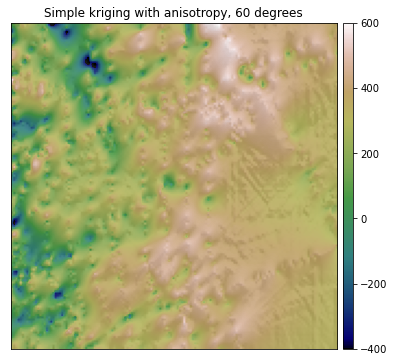

In [8]:
# make hillshade plot for visualizing

# reshape grid
ylen = (ymax + res - ymin)/res
xlen = (xmax + res - xmin)/res
elevation =  np.reshape(spred_trans, (int(ylen), int(xlen)))
elevation = elevation 

hillshade = es.hillshade(elevation, azimuth = 210, altitude = 10) # hillshade

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    elevation,
    ax=ax,
    cmap="gist_earth",
    title="Simple kriging with anisotropy, 60 degrees",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

## SGS with anisotropy

The same approach can be used to implement SGS with anisotropy:

In [9]:
sim = gs.okrige_SGS(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad)  # horizontal orientation
df_sim = pd.DataFrame(sim, columns = ['sim'])
sim_trans = geostats.backtr(df_sim,'sim',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)

sim60 = gs.okrige_SGS(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario2, rad) # 60 degree orientation
df_sim60 = pd.DataFrame(sim60, columns = ['sim45'])
sim60_trans = geostats.backtr(df_sim60,'sim45',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)

100%|████████████████████████████████████| 22500/22500 [03:31<00:00, 106.58it/s]


<Figure size 432x288 with 0 Axes>

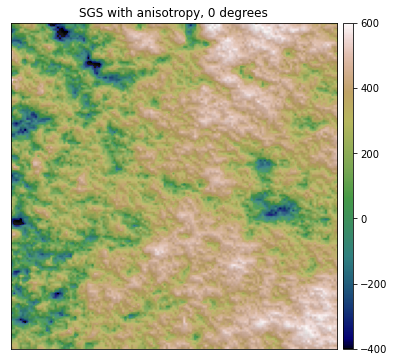

In [10]:
# make hillshade plot for visualizing

# reshape grid
ylen = (ymax + res - ymin)/res
xlen = (xmax + res - xmin)/res
elevation =  np.reshape(sim_trans, (int(ylen), int(xlen)))
elevation = elevation 

hillshade = es.hillshade(elevation, azimuth = 210, altitude = 10) # hillshade

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    elevation,
    ax=ax,
    cmap="gist_earth",
    title="SGS with anisotropy, 0 degrees",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

<Figure size 432x288 with 0 Axes>

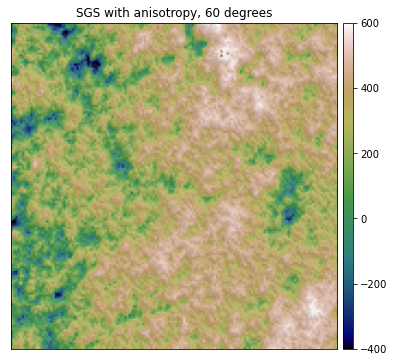

In [11]:
# make hillshade plot for visualizing

# reshape grid
ylen = (ymax + res - ymin)/res
xlen = (xmax + res - xmin)/res
elevation =  np.reshape(sim60_trans, (int(ylen), int(xlen)))
elevation = elevation 

hillshade = es.hillshade(elevation, azimuth = 210, altitude = 10) # hillshade

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    elevation,
    ax=ax,
    cmap="gist_earth",
    title="SGS with anisotropy, 60 degrees",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()